# Select Active High-Quality Wikipedia Contributors

In [126]:
#setup
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import urllib
import json
import time
import itertools
import random
import requests
import re
import os
import nltk
import string
import tqdm
import warnings
import urllib.parse
import time
import random
import matplotlib.colors as mcolors
from collections import defaultdict
from operator import itemgetter
from datetime import datetime, timedelta
from scipy import stats
from dateutil import parser
from pathlib import Path
from matplotlib import rcParams
from collections import ChainMap
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from pattern3 import web

warnings.filterwarnings('ignore')

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = False
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'

def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecessary plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()


## 1. Wikipedia articles

In [127]:
articles_indian = [
    'https://en.wikipedia.org/wiki/Narendra_Modi',
    'https://en.wikipedia.org/wiki/2002_Gujarat_riots',
    'https://en.wikipedia.org/wiki/Ayodhya_dispute',
    'https://en.wikipedia.org/wiki/Kashmir'
]

articles_us = [
    'https://en.wikipedia.org/wiki/Antifa_(United_States)',
    'https://en.wikipedia.org/wiki/Black_Lives_Matter',
    'https://en.wikipedia.org/wiki/Planned_Parenthood',
    'https://en.wikipedia.org/wiki/COVID-19_pandemic',
    'https://en.wikipedia.org/wiki/Israel'
]


In [128]:
titles = [url.split('/')[-1].replace('_', ' ') for url in articles_indian]
titles += [url.split('/')[-1].replace('_', ' ') for url in articles_us]
titles

['Narendra Modi',
 '2002 Gujarat riots',
 'Ayodhya dispute',
 'Kashmir',
 'Antifa (United States)',
 'Black Lives Matter',
 'Planned Parenthood',
 'COVID-19 pandemic',
 'Israel']

In [129]:
files = os.listdir('data/')
files.sort()
files

['2002 Gujarat riots.csv',
 'Antifa (United States).csv',
 'Ayodhya dispute.csv',
 'Black Lives Matter.csv',
 'COVID-19 pandemic.csv',
 'Israel.csv',
 'Kashmir.csv',
 'Narendra Modi.csv',
 'Planned Parenthood.csv',
 'Talk:2002 Gujarat riots.csv',
 'Talk:Antifa (United States).csv',
 'Talk:Ayodhya dispute.csv',
 'Talk:Black Lives Matter.csv',
 'Talk:COVID-19 pandemic.csv',
 'Talk:Israel.csv',
 'Talk:Kashmir.csv',
 'Talk:Narendra Modi.csv',
 'Talk:Planned Parenthood.csv']

## 2. Plot activity trends per article

To get a sense of where/when to look for good editors

In [130]:
def restructure_data(title):

    page_df = pd.read_csv(f'data/{title}.csv', parse_dates=['timestamp'])
    talk_df = pd.read_csv(f'data/talk:{title}.csv', parse_dates=['timestamp'])
    
    page_df['date'] = page_df.timestamp.map(datetime.date)
    talk_df['date'] = talk_df.timestamp.map(datetime.date)
    
    page_daily = page_df.groupby('date').revid.count().reset_index()
    talk_daily = talk_df.groupby('date').revid.count().reset_index()

    first_date = min(page_daily.date.min(), talk_daily.date.min())
    last_date = max(page_daily.date.max(), talk_daily.date.max())
    idx = pd.date_range(first_date, last_date)

    page_daily = page_daily.set_index('date')
    page_daily = page_daily.reindex(idx, fill_value=0)

    talk_daily = talk_daily.set_index('date')
    talk_daily = talk_daily.reindex(idx, fill_value=0)

    page_daily = page_daily.rename(columns={'revid': 'edits'})
    talk_daily = talk_daily.rename(columns={'revid': 'talks'})
    
    daily = page_daily.join(talk_daily)
    
    return daily, idx

In [132]:
len(titles)

9

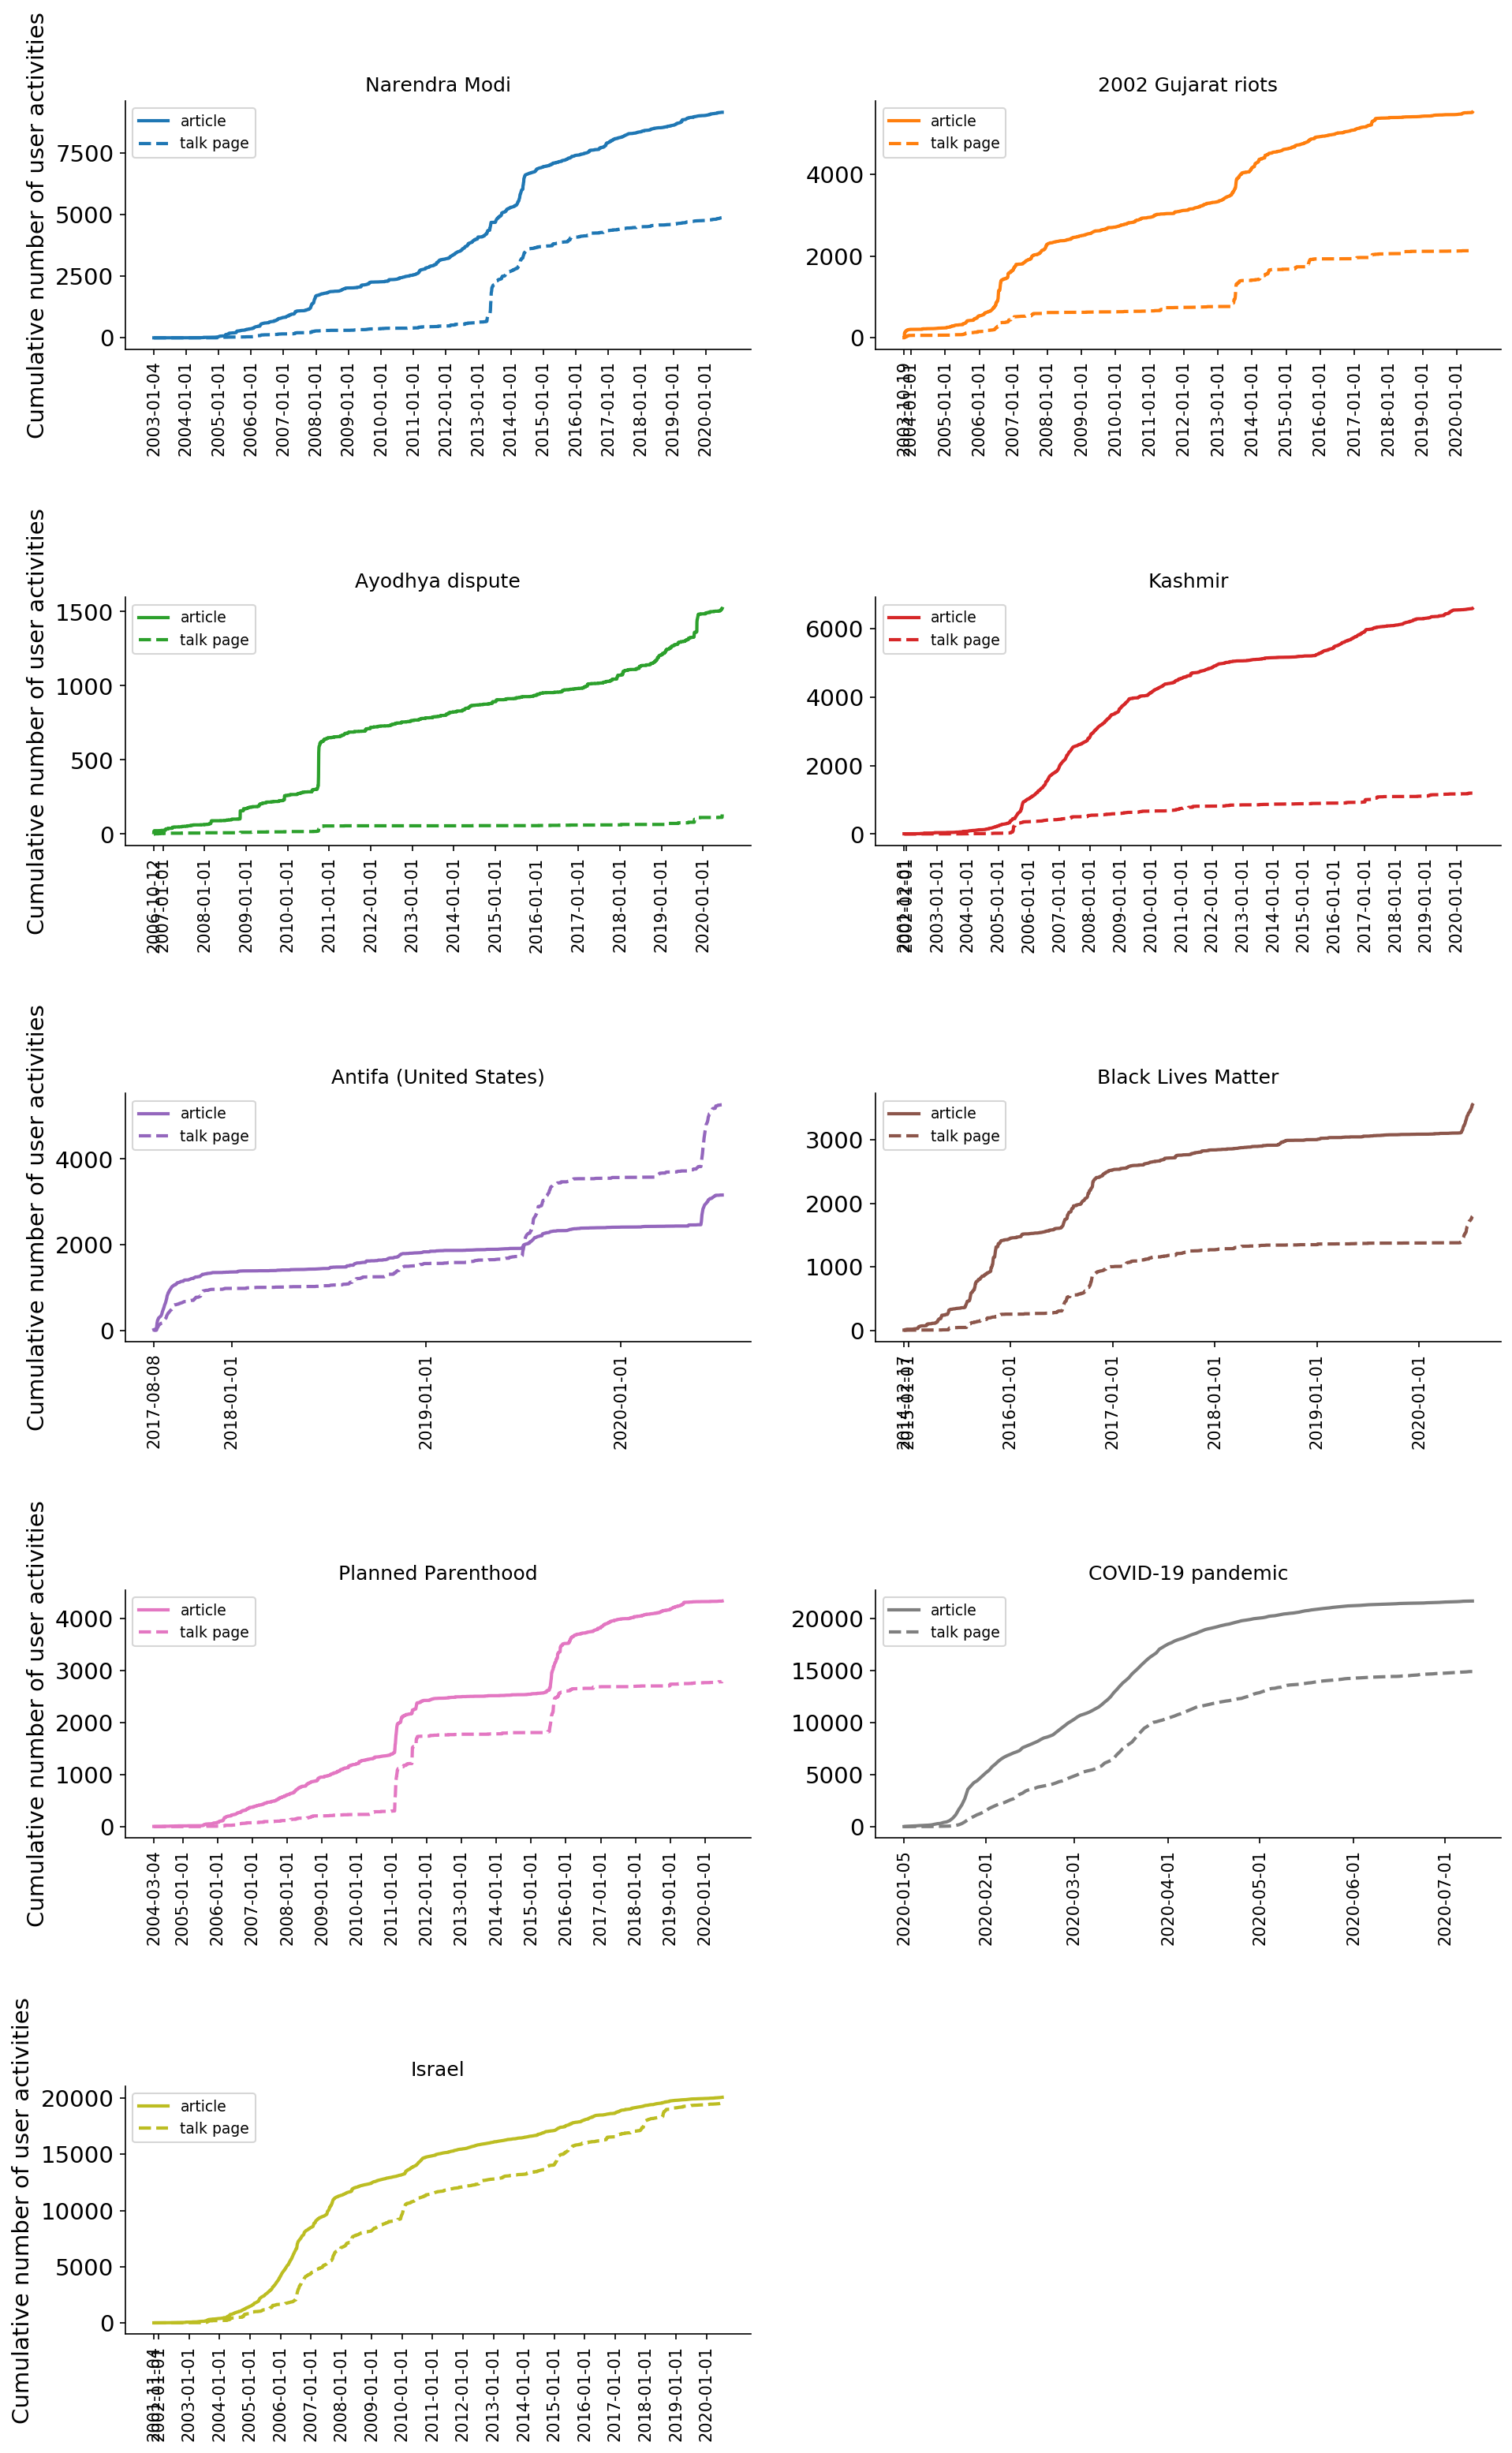

In [268]:
fig, axes = plt.subplots(5, 2, figsize=(15, 25))

for i in range(5):
    for j in range(2):
        
        if i == 4 and j == 1:
            axes[4, 1].set_visible(False)
            continue

    
        daily, idx = restructure_data(titles[i*2+j])

        axes[i, j].plot(daily.index, daily.edits.cumsum(), c=list(mcolors.TABLEAU_COLORS.values())[i*2+j], 
                        label='article')
        axes[i, j].plot(daily.index, daily.talks.cumsum(), c=list(mcolors.TABLEAU_COLORS.values())[i*2+j], 
                        ls='--', label='talk page')

        
        # add date as xtick labels
        xticks_dates = [d for d in idx if d.day==1 and d.month==1]
        if len(xticks_dates) == 0:
            xticks_dates = [d for d in idx if d.day==1]
        if not idx[0] in xticks:
            xticks_dates.insert(0, idx[0])
            
        xticklabels = [d.strftime('%Y-%m-%d') for d in xticks_dates]

        axes[i, j].set_xticks(xticks_dates)
        axes[i, j].set_xticklabels(labels=xticklabels, rotation=90, fontsize=10)

        axes[i, j].set_title(titles[i*2+j], fontsize=12)
        remove_border(axes[i, j])
        axes[i, j].legend(fontsize=9)
        
        if j == 0:
            axes[i, j].set_ylabel('Cumulative number of user activities')
        
 
fig.subplots_adjust(hspace=1)

## 3. Find the most active and qualified editors

<font color='orange' size=4>Use four metrics</font>
* Number of edits on article
* Size of new content added to article (ignore contributions with negative size, i.e. remove content)
* Number of comments/activities on talk page
* Size of new content added to discussion (ignore contributions with negative size, i.e. remove content)


<font color='crimson' size=4>Strategy</font>

1. Select top 20 editors in each of the four metrics (there can be overlaps)
2. Drop editors who never wrote on the article (some users only remove article content or only join talk pages)
3. Create a table that lists all the editors' names, their ranks in the four metrics (rank 1 is the best), sum of ranks (the smaller the better), most active years, and the latest active years. 
4. Contact user on their wikipedia talk pages. Leave a message at https://en.wikipedia.org/wiki/User:{username} 

For example, https://en.wikipedia.org/wiki/User:Okedem

Xiaolin: Happy to discuss more of the selection of editors and way to contact them!

In [148]:
with open ('data/bots.txt', 'r') as f:
    bots = f.readlines()
    
bots = [b.strip('\n') for b in bots]
bots[:10]

['"Quote"bot',
 '$amSpadeBot',
 '(1.VSNCT)Bot',
 '123Hedgebot456',
 '126Bot',
 '1VeertjeBot',
 '28bot',
 '3RRBot',
 '718 Bot',
 '7SeriesBOT']

In [235]:
def get_rank(user, ls):
    if user in ls:
        return ls.index(user) + 1
    return None


In [274]:
def get_most_common_year(years):
    freq = years.value_counts()
    if sum(freq==max(freq)) > 1:
        return max(freq[freq==max(freq)].index)
    else:
        return years.mode()[0]

In [275]:
def find_top_users(title):
    print(title, '\n')
    
    page_df = pd.read_csv(f'data/{title}.csv', parse_dates=['timestamp'])
    talk_df = pd.read_csv(f'data/talk:{title}.csv', parse_dates=['timestamp'])
    
    # remove bots
    page_df = page_df[~page_df.user.isin(bots)]
    page_df = page_df.reset_index(drop=True)
    
    talk_df = talk_df[~talk_df.user.isin(bots)]
    talk_df = talk_df.reset_index(drop=True)    
    
    # track contribution size
    page_df['size_changed'] = page_df['size'].diff()
    talk_df['size_changed'] = talk_df['size'].diff()

    # first row became None from operation above. put original value back 
    page_df.loc[0, 'size_changed'] = page_df.loc[0, 'size']
    talk_df.loc[0, 'size_changed'] = talk_df.loc[0, 'size']
    
    
    # list top 20 for each metric. there are overlaps
    everyone = page_df.user.value_counts()[:20].index.tolist() + \
                talk_df.user.value_counts()[:20].index.tolist() + \
                page_df[page_df.size_changed>0].groupby('user').size_changed.sum().sort_values(ascending=False)[:20].index.tolist() + \
                talk_df[talk_df.size_changed>0].groupby('user').size_changed.sum().sort_values(ascending=False)[:20].index.tolist()
    print('overall users:', len(everyone))

    everyone = list(set(everyone))
    print('unique users:', len(everyone))

    # must have edited article content
    everyone = list(set(everyone) & set(page_df.user))
    print('unique and edited article:', len(everyone))
    
    
    # finalist ranks
    finalists = pd.DataFrame({'user': everyone})
    finalists['rank_by_number_edit'] = finalists.user.map(lambda user: get_rank(user, page_df.user.value_counts().index.tolist()))
    finalists['rank_by_number_discuss'] = finalists.user.map(lambda user: get_rank(user, talk_df.user.value_counts().index.tolist()))
    finalists['rank_by_article_size_added'] = finalists.user.map(lambda user: get_rank(user, page_df[page_df.size_changed>0].groupby('user').size_changed.sum().sort_values(ascending=False).index.tolist()))
    finalists['rank_by_discuss_size_added'] = finalists.user.map(lambda user: get_rank(user, talk_df[talk_df.size_changed>0].groupby('user').size_changed.sum().sort_values(ascending=False).index.tolist()))


    # add up all ranks, ignore missing values
    finalists['sum_ranks'] = finalists.sum(1)
    finalists = finalists.sort_values('sum_ranks') # the smaller the better
    finalists = finalists.reset_index(drop=True)
    
    
    # find active years
    page_df['year'] = page_df.timestamp.map(lambda ts: ts.year)

    active_years = page_df.groupby('user').year.agg(lambda vals: get_most_common_year(vals)).reset_index()
    active_years = active_years.rename(columns={'year': 'most_active_year'})
    active_years = active_years.merge(page_df.groupby('user').year.max().reset_index(), on='user')
    active_years = active_years.rename(columns={'year': 'last_active_year'})

    # merge
    finalists = finalists.merge(active_years, on='user', how='left')
    
    return finalists

In [276]:
find_top_users(titles[0])

Narendra Modi 

overall users: 80
unique users: 49
unique and edited article: 44


,user,rank_by_number_edit,rank_by_number_discuss,rank_by_article_size_added,rank_by_discuss_size_added,sum_ranks,most_active_year,last_active_year
0,Vanamonde93,2,2.0,5.0,4.0,13.0,2014,2020
1,Sitush,1,1.0,2.0,29.0,33.0,2013,2019
2,AdhunikaSarvajna,10,6.0,10.0,8.0,34.0,2013,2017
3,RegentsPark,5,4.0,23.0,3.0,35.0,2013,2020
4,Maunus,13,8.0,12.0,5.0,38.0,2013,2014
5,Yogesh Khandke,8,7.0,29.0,10.0,54.0,2014,2014
6,Relata refero,19,27.0,6.0,7.0,59.0,2008,2008
7,Darkness Shines,17,10.0,14.0,19.0,60.0,2013,2014
8,Capankajsmilyo,6,12.0,47.0,13.0,78.0,2016,2019
9,Imc,27,19.0,40.0,NaN,86.0,2006,2006


In [277]:
find_top_users(titles[1])

2002 Gujarat riots 

overall users: 80
unique users: 55
unique and edited article: 49


,user,rank_by_number_edit,rank_by_number_discuss,rank_by_article_size_added,rank_by_discuss_size_added,sum_ranks,most_active_year,last_active_year
0,Darkness Shines,1,1.0,4.0,3.0,9.0,2013,2014
1,Democrate2003,17,NaN,NaN,NaN,17.0,2003,2003
2,Vanamonde93,3,2.0,9.0,18.0,32.0,2014,2020
3,Shiva's Trident,2,5.0,10.0,21.0,38.0,2006,2006
4,Maunus,18,3.0,11.0,9.0,41.0,2013,2017
5,Kautilya3,7,6.0,23.0,22.0,58.0,2015,2020
6,Lkadvani,13,14.0,18.0,17.0,62.0,2006,2006
7,Wasifwasif,9,34.0,33.0,NaN,76.0,2010,2014
8,RegentsPark,15,15.0,12.0,39.0,81.0,2015,2020
9,Bakasuprman,4,16.0,27.0,37.0,84.0,2007,2008


In [278]:
find_top_users(titles[2])

Ayodhya dispute 

overall users: 66
unique users: 52
unique and edited article: 46


,user,rank_by_number_edit,rank_by_number_discuss,rank_by_article_size_added,rank_by_discuss_size_added,sum_ranks,most_active_year,last_active_year
0,Vanamonde93,2,3.0,1.0,NaN,6.0,2014,2020
1,Kautilya3,1,1.0,6.0,NaN,8.0,2019,2020
2,72.179.45.224,4,NaN,5.0,NaN,9.0,2008,2008
3,128.122.253.228,10,NaN,NaN,NaN,10.0,2008,2008
4,Nadeemkhan1947,20,NaN,3.0,NaN,23.0,2010,2010
5,117.254.75.49,19,NaN,12.0,NaN,31.0,2010,2010
6,Mdw0,5,28.0,2.0,NaN,35.0,2009,2015
7,130.76.32.99,24,NaN,13.0,NaN,37.0,2011,2011
8,SPat,3,5.0,26.0,6.0,40.0,2010,2012
9,Nizil Shah,6,2.0,31.0,3.0,42.0,2019,2019


In [279]:
find_top_users(titles[3])

Kashmir 

overall users: 80
unique users: 65
unique and edited article: 58


,user,rank_by_number_edit,rank_by_number_discuss,rank_by_article_size_added,rank_by_discuss_size_added,sum_ranks,most_active_year,last_active_year
0,Fowler&fowler,1,1.0,1.0,18.0,21.0,2007,2020
1,Angelo De La Paz,33,NaN,19.0,NaN,52.0,2008,2008
2,Philg88,44,NaN,9.0,NaN,53.0,2015,2015
3,Idleguy,9,14.0,32.0,NaN,55.0,2005,2006
4,Ragib,14,4.0,30.0,15.0,63.0,2005,2010
5,Anonymous editor,3,3.0,33.0,26.0,65.0,2005,2006
6,70.34.252.126,10,NaN,57.0,NaN,67.0,2005,2005
7,Kautilya3,2,2.0,59.0,5.0,68.0,2016,2020
8,204.8.195.187,89,NaN,7.0,NaN,96.0,2006,2006
9,Swatay,18,NaN,83.0,NaN,101.0,2012,2012


In [280]:
find_top_users(titles[4])

Antifa (United States) 

overall users: 80
unique users: 47
unique and edited article: 42


,user,rank_by_number_edit,rank_by_number_discuss,rank_by_article_size_added,rank_by_discuss_size_added,sum_ranks,most_active_year,last_active_year
0,Doug Weller,6,2.0,8,1.0,17.0,2017,2020
1,Davide King,1,4.0,1,23.0,29.0,2020,2020
2,Arms & Hearts,5,10.0,7,9.0,31.0,2019,2020
3,Aquillion,7,8.0,18,4.0,37.0,2019,2020
4,NedFausa,2,14.0,9,13.0,38.0,2020,2020
5,Bobfrombrockley,3,11.0,12,19.0,45.0,2017,2020
6,Simonm223,16,1.0,33,7.0,57.0,2018,2019
7,PackMecEng,23,5.0,26,10.0,64.0,2018,2020
8,Mbsyl,30,13.0,15,20.0,78.0,2019,2019
9,Dumuzid,20,9.0,44,8.0,81.0,2019,2019


In [281]:
find_top_users(titles[5])

Black Lives Matter 

overall users: 80
unique users: 55
unique and edited article: 51


,user,rank_by_number_edit,rank_by_number_discuss,rank_by_article_size_added,rank_by_discuss_size_added,sum_ranks,most_active_year,last_active_year
0,Jumplike23,1,4.0,5.0,1.0,11.0,2015,2017
1,Scoundr3l,3,1.0,13.0,9.0,26.0,2016,2016
2,Starship.paint,6,26.0,6.0,NaN,38.0,2015,2015
3,Malik Shabazz,2,3.0,31.0,2.0,38.0,2016,2019
4,72.176.56.38,23,NaN,20.0,NaN,43.0,2015,2015
5,MrCharlesBlack,41,NaN,15.0,NaN,56.0,2017,2017
6,PeterTheFourth,21,21.0,18.0,NaN,60.0,2015,2017
7,Nblund,22,5.0,22.0,11.0,60.0,2016,2019
8,Zpeopleheart,59,NaN,8.0,NaN,67.0,2015,2015
9,MShabazz,7,7.0,46.0,8.0,68.0,2016,2018


In [282]:
find_top_users(titles[6])

Planned Parenthood 

overall users: 80
unique users: 53
unique and edited article: 50


,user,rank_by_number_edit,rank_by_number_discuss,rank_by_article_size_added,rank_by_discuss_size_added,sum_ranks,most_active_year,last_active_year
0,WikiManOne,1,1.0,6.0,6.0,14.0,2011,2011
1,MastCell,5,8.0,3.0,NaN,16.0,2007,2018
2,Mattnad,3,2.0,33.0,7.0,45.0,2011,2015
3,Lyrl,17,35.0,2.0,NaN,54.0,2006,2009
4,ClassicSC,47,NaN,8.0,NaN,55.0,2008,2008
5,Checkingfax,2,13.0,23.0,23.0,61.0,2016,2018
6,Roscelese,8,9.0,40.0,17.0,74.0,2011,2018
7,Slugger O'Toole,6,25.0,13.0,30.0,74.0,2015,2015
8,Uncle Milty,28,37.0,12.0,NaN,77.0,2010,2015
9,PhGustaf,15,28.0,31.0,8.0,82.0,2011,2011


In [283]:
find_top_users(titles[7])

COVID-19 pandemic 

overall users: 80
unique users: 54
unique and edited article: 50


,user,rank_by_number_edit,rank_by_number_discuss,rank_by_article_size_added,rank_by_discuss_size_added,sum_ranks,most_active_year,last_active_year
0,Doc James,1,1.0,7.0,1.0,10.0,2020,2020
1,Sdkb,8,3.0,1.0,2.0,14.0,2020,2020
2,Renamed user 923716947x,7,2.0,12.0,7.0,28.0,2020,2020
3,Sleath56,9,8.0,8.0,13.0,38.0,2020,2020
4,Wikmoz,22,6.0,47.0,5.0,80.0,2020,2020
5,Ozzie10aaaa,2,4.0,30.0,57.0,93.0,2020,2020
6,Hallooooed,15,NaN,90.0,NaN,105.0,2020,2020
7,Hzh,5,5.0,10.0,88.0,108.0,2020,2020
8,Tsukide,10,45.0,20.0,40.0,115.0,2020,2020
9,Graeme Bartlett,40,10.0,69.0,22.0,141.0,2020,2020


In [284]:
find_top_users(titles[8])

Israel 

overall users: 80
unique users: 54
unique and edited article: 49


,user,rank_by_number_edit,rank_by_number_discuss,rank_by_article_size_added,rank_by_discuss_size_added,sum_ranks,most_active_year,last_active_year
0,Tariqabjotu,2,4.0,6.0,9.0,21.0,2007,2010
1,Jayjg,7,7.0,5.0,10.0,29.0,2005,2009
2,Okedem,3,1.0,33.0,1.0,38.0,2010,2010
3,Tawkerbot2,77,NaN,1.0,NaN,78.0,2006,2006
4,Telaviv1,6,14.0,30.0,31.0,81.0,2007,2019
5,Jpgordon,12,27.0,11.0,40.0,90.0,2006,2010
6,Gilabrand,5,47.0,39.0,3.0,94.0,2007,2012
7,Triggerhippie4,1,10.0,86.0,2.0,99.0,2017,2018
8,Doron,20,29.0,7.0,45.0,101.0,2007,2007
9,Amoruso,8,18.0,51.0,24.0,101.0,2006,2010
